<a href="https://colab.research.google.com/github/NguyenTatDat21/mlclass/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

In [0]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

### Get a sample stock price from 2019-01-01 to today

In [0]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2019-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.766861,41025300


### Extract the Close price column to plot

In [0]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

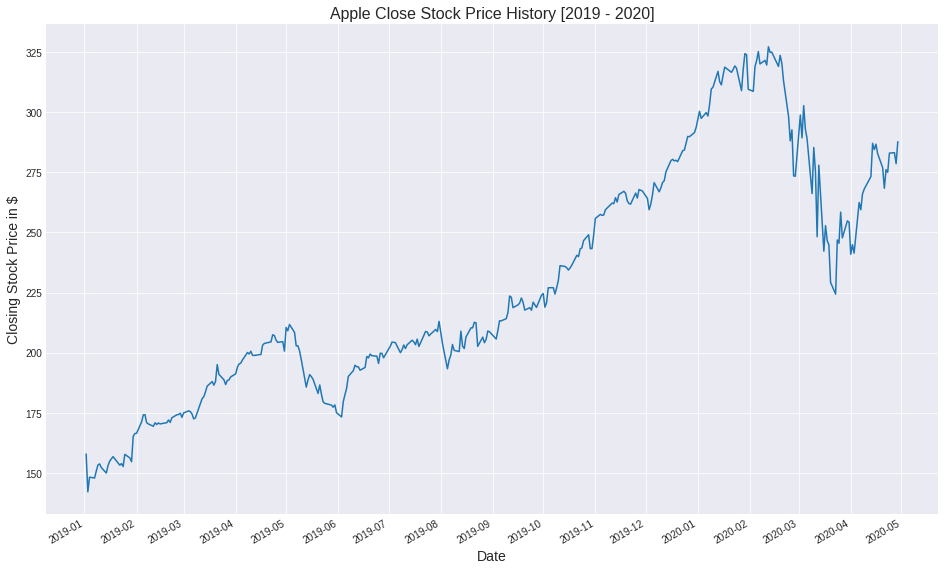

In [0]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Get stock of Apple, Google, Microsoft, Amazon, Facebook via Yahoo Finance

In [0]:
def get_close_stock_price(codes, start_date='2019-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
df = pd.read_csv('close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003
2019-01-08,150.750000,1085.369995,102.800003,1656.579956,142.529999


In [0]:
df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', name='Date', length=334, freq=None)

In [0]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

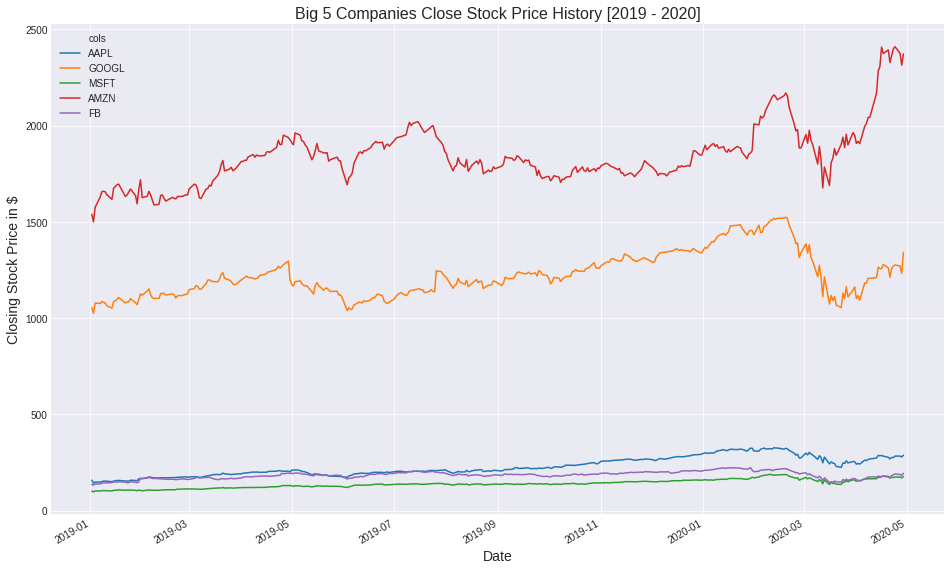

In [0]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression
Use history = number of days before prediction date

In [0]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=3)

# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

### Create a Linear Regression Model to predict stock price

Use all company prices as input

In [0]:
clf = LinearRegression(normalize = True)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
for i in range(5):
    print(df.columns[i], mean_squared_error(y_test[:,i], ypred[:,i]))
print(mean_squared_error(y_test, ypred))


AAPL 88.15764222840333
GOOGL 1546.8551951762681
MSFT 31.91661436567352
AMZN 2699.117455515644
FB 61.305537425032206
885.4704889422043


Only use single company price

In [0]:
for i in range(5):
    clf = LinearRegression(normalize = True)
    clf.fit(X_train[:,i::5], y_train)
    ypred[:,i] = clf.predict(X_test[:,i::5])[:,i]
    print(df.columns[i], mean_squared_error(y_test[:,i], ypred[:,i]))

print(mean_squared_error(y_test, ypred))

AAPL 93.52712101996634
GOOGL 1602.068408461439
MSFT 31.265618458447715
AMZN 2867.824581490712
FB 33.800354797077084
925.6972168455284


Conclusion : 
Use all company prices deliver average lower error






Added L2 Regulization

In [0]:

for i in range(5):
    clf = Ridge(alpha = 0.013, normalize = True)
    clf.fit(X_train[:,i::5], y_train)
    ypred[:,i] = clf.predict(X_test[:,i::5])[:,i]
    print(df.columns[i], mean_squared_error(y_test[:,i], ypred[:,i]))
    print(clf.coef_[i])

print(mean_squared_error(y_test, ypred))

    

AAPL 83.00673953281175
[0.17625694 0.24192336 0.57349325]
GOOGL 1409.448335958713
[0.11932309 0.00733704 0.84067932]
MSFT 26.54045479491269
[0.19521215 0.22729336 0.5607111 ]
AMZN 2791.3345211402284
[0.10915113 0.01636068 0.82804023]
FB 31.67428564775197
[0.03849143 0.15242364 0.7643777 ]
868.4008674148839


In [0]:
mean_squared_error(y_test[:,1], ypred[:,1])

1409.448335958713

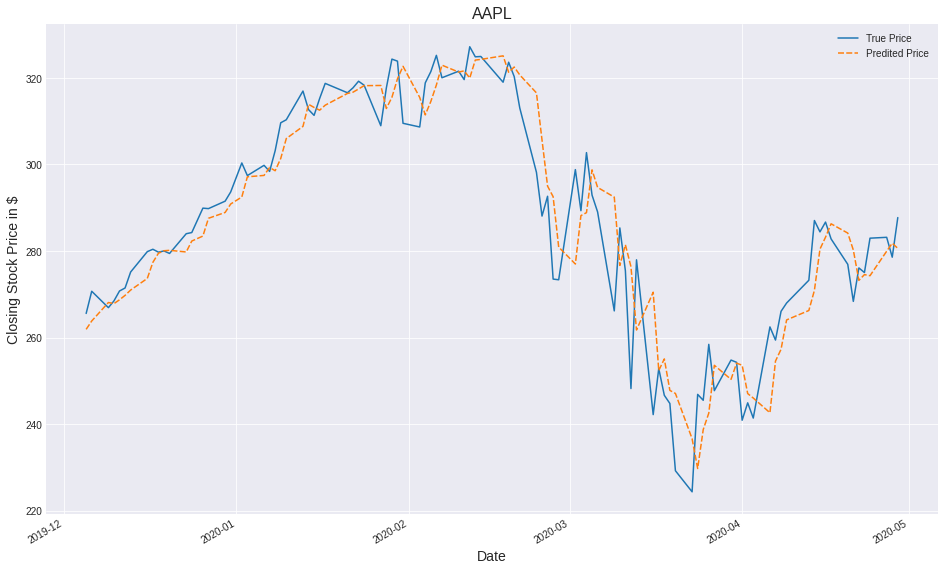

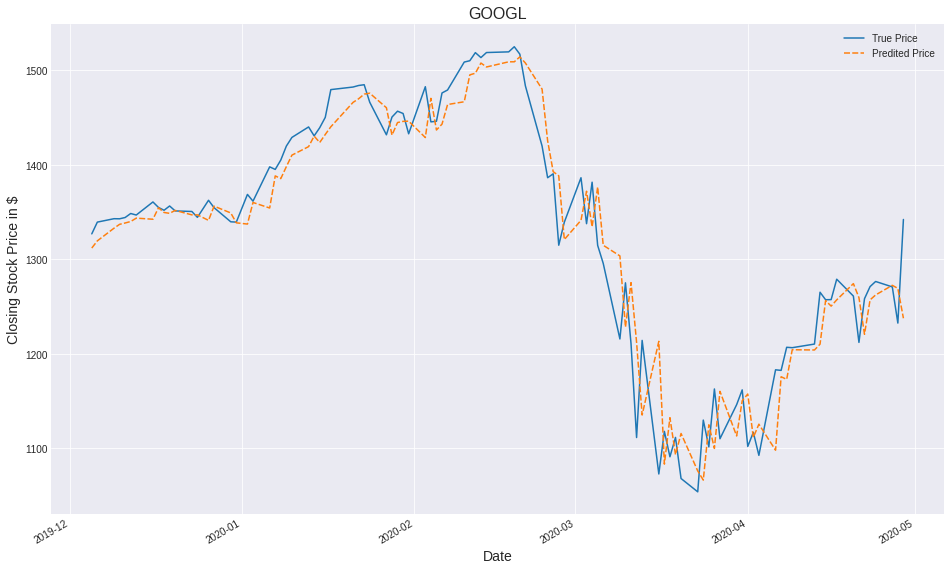

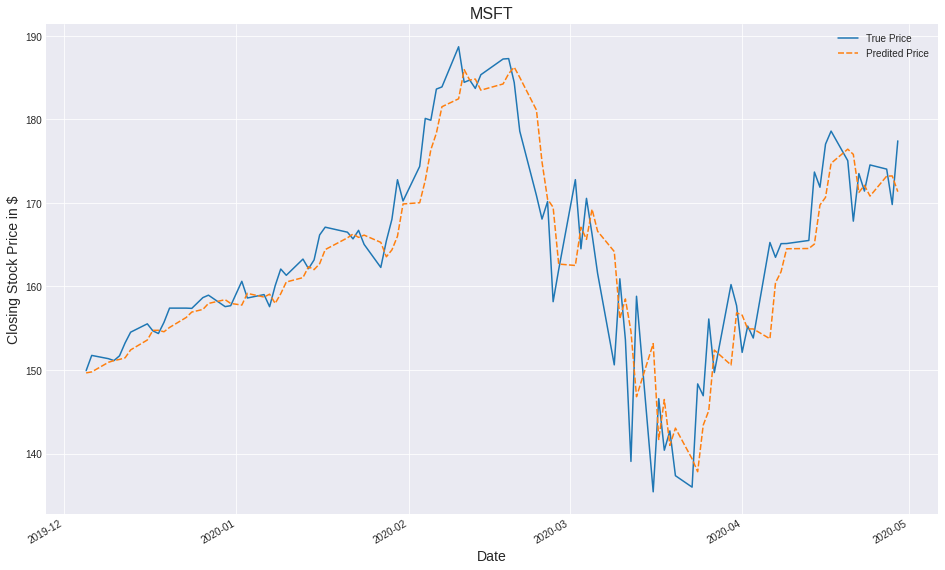

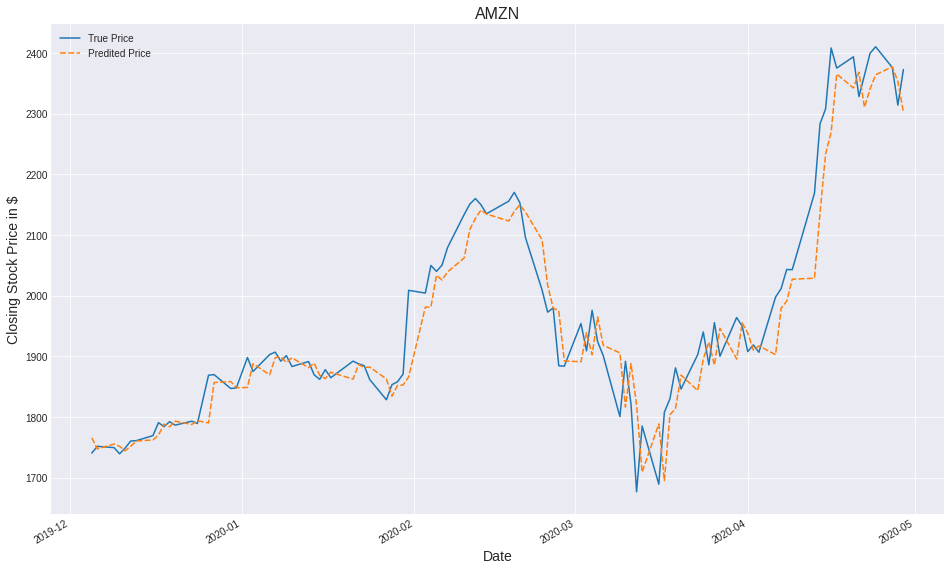

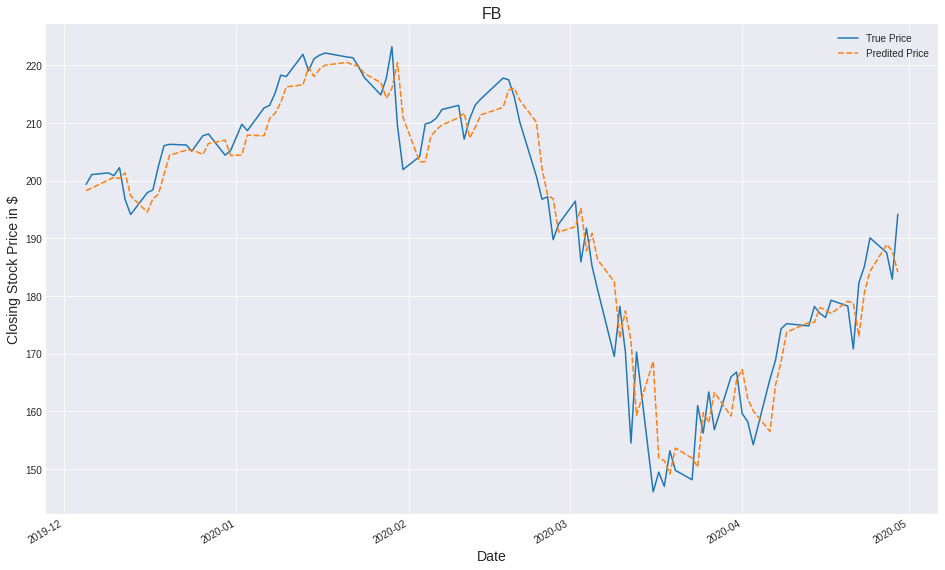

In [0]:
for i in range(5):

    df_plot = pd.DataFrame({"True Price": y_test[:,i], 'Predited Price': ypred[:,i]}, index=dates_test)

    # Create subplots to plot graph and control axes
    fig, ax = plt.subplots(figsize=(16,10))
    sns.lineplot(data=df_plot)

    # Format the ticks
    loc = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

    # Set figure title
    plt.title(df.columns[i], fontsize=16)
    # Set x label
    plt.xlabel('Date', fontsize=14)
    # Set y label
    plt.ylabel('Closing Stock Price in $', fontsize=14)

    # Rotate and align the x labels
    fig.autofmt_xdate()

    # Show plot
    plt.show()